## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
The pipeline was implemented within a class named LaneDetection_From_Video. Scroll down to "Video Pipeline" to see the methods of the class and run the pipeline on a video.  If you want to trace my steps while implementing this project, start from here.

 ##  Compute camera calibration and distortion coefficients using a checkerboard

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline

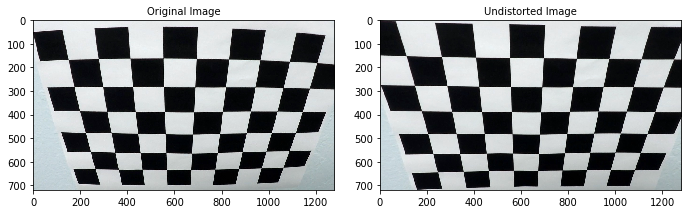

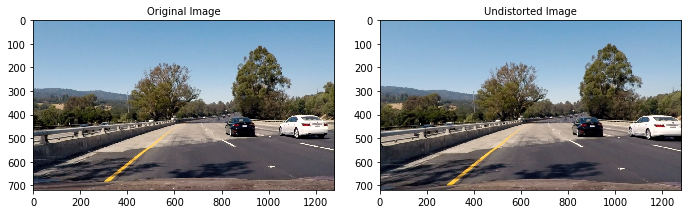

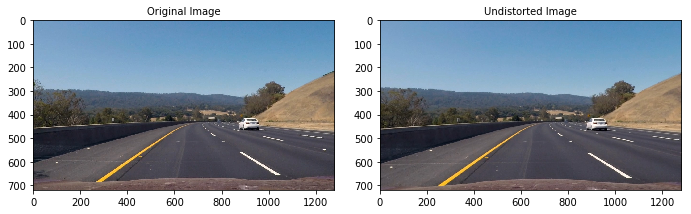

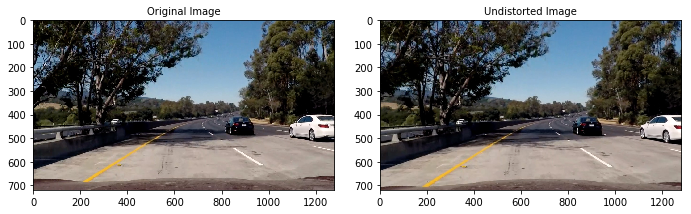

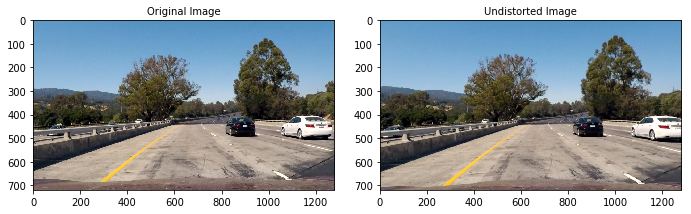

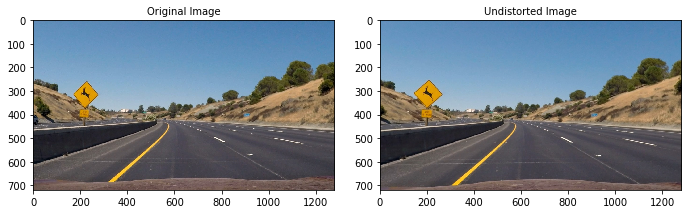

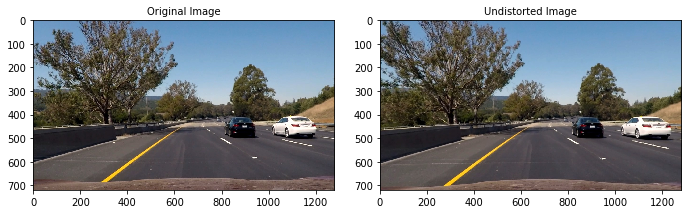

In [2]:

def cal_undistort(img, mtx,dist):    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def calibrate_camera(images, nx=9, ny=6):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.


    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    if objpoints: #not empty        
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    else:        
        ret, mtx, dist, rvecs, tvecs = (None, None, None, None, None)

    return mtx, dist


# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
mtx, dist=calibrate_camera(images)

# for fname in images:
fname='./camera_cal/calibration2.jpg'
img = cv2.imread(fname)
undistorted=cal_undistort(img, mtx,dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

fname = 'test_images/test*.jpg'
images = glob.glob(fname)
for fname in images:
    img = cv2.imread(fname)
    undistorted=cal_undistort(img, mtx,dist)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
    f.tight_layout()
    #convert to RGB
    ax1.imshow(img[:,:,::-1])
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(undistorted[:,:,::-1])
    ax2.set_title('Undistorted Image', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 



## Define color transforms and gradient functions


In [3]:

def abs_sobel_thresh(img_gray, orient='x', sobel_kernel=3 , abs_thresh=(0, 255)):
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(img_gray, cv2.CV_64F, orient=='x', orient=='y', ksize=sobel_kernel)
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 4) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1
    # 5) Return the mask as a binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output

def mag_thresh(img_gray, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 2) Calculate the magnitude 
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 3) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # 4) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 5) Return the mask as a binary_output image
    binary_output = np.copy(sxbinary) 
    return binary_output
    

def dir_threshold(img_gray, sobel_kernel=3, dir_thresh=(0, np.pi/2)):    

    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 2) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 3) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 4) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(grad_dir)
    binary_output[(grad_dir >= dir_thresh[0]) & (grad_dir <= dir_thresh[1])] = 1

    # 5) Return the mask as a binary_output image
    return binary_output

def example_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
#     return color_binary
    return s_binary

def color_thresh(rgb_img, color_space,channel_num, low_threshold, high_threshold):
    
    if color_space is 'RGB':
        img_color=np.copy(rgb_img)   
    elif color_space is 'HLS':
        img_color=cv2.cvtColor(rgb_img,cv2.COLOR_RGB2HLS)    
    elif color_space is 'HSV':
        img_color=cv2.cvtColor(rgb_img,cv2.COLOR_RGB2HSV)   
    elif color_space is 'LAB':
        img_color=cv2.cvtColor(rgb_img,cv2.COLOR_RGB2Lab) 
    else:
        print('Invalid color space')    
    img_channel=img_color[:,:,channel_num]
    binary_output = np.zeros_like(img_channel)
    binary_output[(img_channel > low_threshold) & (img_channel <= high_threshold)] = 1
    return binary_output


def mask_roi(img, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def region_of_interest(img, vertices):
    img_roi=cv2.fillPoly(img, vertices, [0,255,0])
    return img_roi


## Tune Image Processing Parameters


Text(0.5,1,'Processed image')

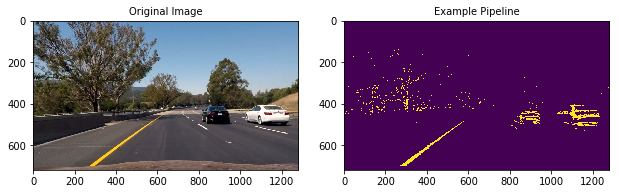

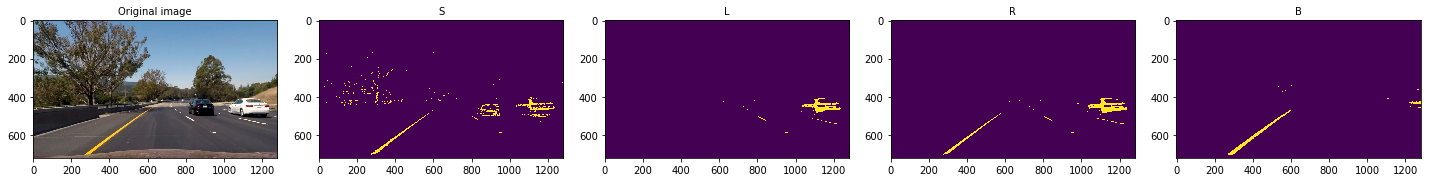

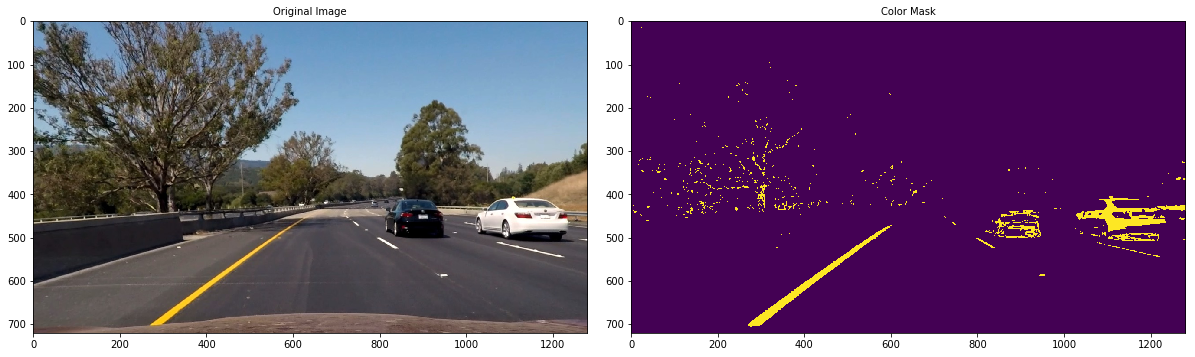

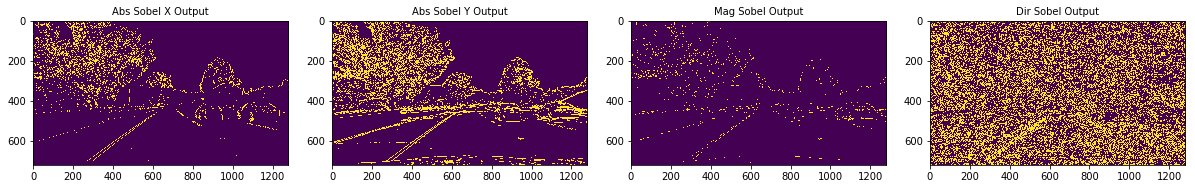

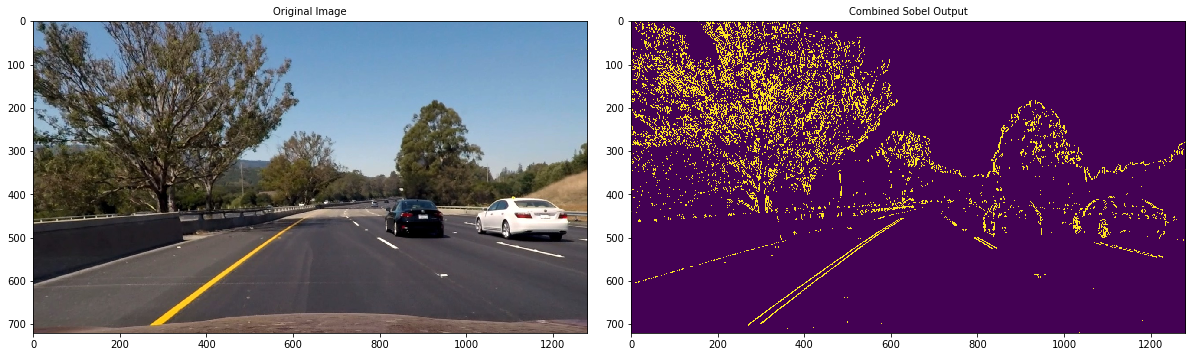

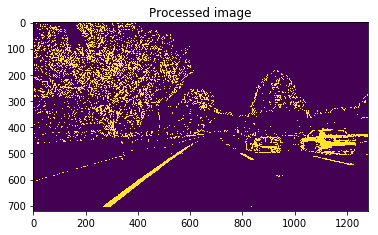

In [4]:
fname = 'test_images/test6.jpg'
images = glob.glob(fname)
#for fname in images:
img_test = cv2.imread(fname)
img_test= cv2.cvtColor(img_test,cv2.COLOR_BGR2RGB)
img=cal_undistort(np.copy(img_test), mtx,dist)
#print('image size=',cv2.imread(images[0]).shape[:2])
img_size=img.shape

img_processed_binary=example_pipeline(img)
img_binary_size=img_processed_binary.shape
#print('binary_mage_size=',img_binary_size)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(img_processed_binary)
ax2.set_title('Example Pipeline', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


#-----------------Tune Color--------------------#

#img=get_top_down_view(img)

r_thresh_low =220#should be high for test 1 and 5
r_thresh_high =255
s_thresh_low = 190
s_thresh_high = 255
l_thresh_low = 225
l_thresh_high = 255
b_thresh_low =155
b_thresh_high =255


#The S channel does a good job of highlighting yellow lines
img_s_mask=color_thresh(img, color_space='HLS',channel_num=2, low_threshold=s_thresh_low, high_threshold=s_thresh_high)
#Adding for robustness to light
img_l_mask=color_thresh(img, color_space='HLS',channel_num=1, low_threshold=l_thresh_low, high_threshold=l_thresh_high)
#The R channel does a reasonable job of highlighting the lines
img_r_mask=color_thresh(img, color_space='RGB',channel_num=0, low_threshold=r_thresh_low , high_threshold=r_thresh_high)
#B channel in Lab for light sensitivity
img_b_mask=color_thresh(img, color_space='LAB',channel_num=2, low_threshold=b_thresh_low , high_threshold=b_thresh_high)

 
    
f_color, (ax1_color, ax2_color,ax3_color,ax4_color,ax5_color) = plt.subplots(1, 5, figsize=(20, 3))
f_color.tight_layout()
ax1_color.imshow(img)
ax1_color.set_title('Original image', fontsize=10)
ax2_color.imshow(img_s_mask)
ax2_color.set_title('S', fontsize=10)
ax3_color.imshow(img_l_mask)
ax3_color.set_title('L', fontsize=10)
ax4_color.imshow(img_r_mask)
ax4_color.set_title('R', fontsize=10)
ax5_color.imshow(img_b_mask)
ax5_color.set_title('B', fontsize=10)

#Combined
img_combined_color=np.zeros((img_size[0],img_size[1]))
img_combined_color[((img_l_mask == 1) | (img_b_mask == 1) | (img_s_mask == 1)) ] = 1
# img_combined_color[((img_l_mask == 1) | (img_r_mask == 1) | (img_s_mask == 1)) ] = 1 #similar performance



f_combined_color_thresh, (ax1_combined_color_thresh, ax2_combined_color_thresh) = plt.subplots(1, 2, figsize=(16, 6))
f_combined_color_thresh.tight_layout()
ax1_combined_color_thresh.imshow(img)
ax1_combined_color_thresh.set_title('Original Image', fontsize=10)
ax2_combined_color_thresh.imshow(img_combined_color)
ax2_combined_color_thresh.set_title('Color Mask', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



#-----------------Tune Sobel--------------------#
# Convert to HLS space
hls = cv2.cvtColor(np.copy(img), cv2.COLOR_RGB2HLS)
# Separate and get the S channel
#img_s = hls[:, :, 2] #works better with grady
img_s = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)#doesn't work with grady

abs_ksize=3
mag_ksize=3
dir_ksize=3
img_gradx = abs_sobel_thresh(img_s, orient='x', sobel_kernel=abs_ksize, abs_thresh=(30, 120))
img_grady = abs_sobel_thresh(img_s, orient='y', sobel_kernel=abs_ksize, abs_thresh=(20, 120))
img_mag_binary = mag_thresh(img_s, sobel_kernel=mag_ksize, mag_thresh=(70, 100))
img_dir_binary = dir_threshold(img_s, sobel_kernel=dir_ksize, dir_thresh=(0.7, 1.3))

img_combined_edges=np.zeros_like(img_s)
img_combined_edges[(img_gradx == 1) | ((img_mag_binary == 1) & (img_dir_binary == 1)) ] = 1
# img_combined_edges[((img_gradx == 1) & (img_grady == 1)) | ((img_mag_binary == 1) & (img_dir_binary == 1)) ] = 1
#sobel_y detects the tree shadow:undesirable, schannel somewhat has the same problem

f_sobel,(ax1_sobel,ax2_sobel,ax3_sobel,ax4_sobel)=plt.subplots(1, 4, figsize=(16, 3))
f_sobel.tight_layout()
ax1_sobel.imshow(img_gradx)
ax1_sobel.set_title('Abs Sobel X Output', fontsize=10)
ax2_sobel.imshow(img_grady)
ax2_sobel.set_title('Abs Sobel Y Output', fontsize=10)
ax3_sobel.imshow(img_mag_binary)
ax3_sobel.set_title('Mag Sobel Output', fontsize=10)
ax4_sobel.imshow(img_dir_binary)
ax4_sobel.set_title('Dir Sobel Output', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f_combined, (ax1_combined, ax2_combined) = plt.subplots(1, 2, figsize=(16, 6))
f_combined.tight_layout()
ax1_combined.imshow(img)
ax1_combined.set_title('Original Image', fontsize=10)
ax2_combined.imshow(img_combined_edges)
ax2_combined.set_title('Combined Sobel Output', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


img_combined=np.zeros_like(img_s)
img_combined[((img_combined_edges == 1) | (img_combined_color == 1)) ] = 1
plt.figure()
plt.imshow(img_combined)
plt.title('Processed image')





## Perspective transform to get birds-eye view

Text(0.5,1,'Undistorted and Warped Image After Processing')

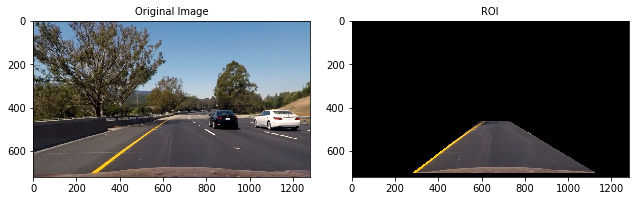

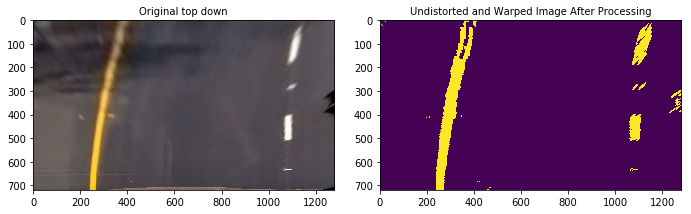

In [5]:
def get_top_down_view(img,src,dst):
    #input is undist
    img_size=(img.shape[1],img.shape[0])
  
    M = cv2.getPerspectiveTransform(src, dst)    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

src = np.float32(
    [[280,  700],  # Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right

dst = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right 
        
        

top_down_color = get_top_down_view(img_combined,src,dst)
img_original_top_down=get_top_down_view(img,src,dst)

img_region_of_interest=mask_roi(img, np.int_([src]))
f_roi, (ax1_roi, ax2_roi) = plt.subplots(1, 2, figsize=(9, 6))
f_roi.tight_layout()
ax1_roi.imshow(img)
ax1_roi.set_title('Original Image', fontsize=10)
ax2_roi.imshow(img_region_of_interest)
ax2_roi.set_title('ROI', fontsize=10)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
f.tight_layout()
ax1.imshow(img_original_top_down)
ax1.set_title('Original top down', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
ax2.imshow(top_down_color)
ax2.set_title('Undistorted and Warped Image After Processing', fontsize=10)





## Fit a curve to the lane boundary


Curvatures, dist from center= (877.0304451585951, 492.435165371665, 0.5555882441265171)


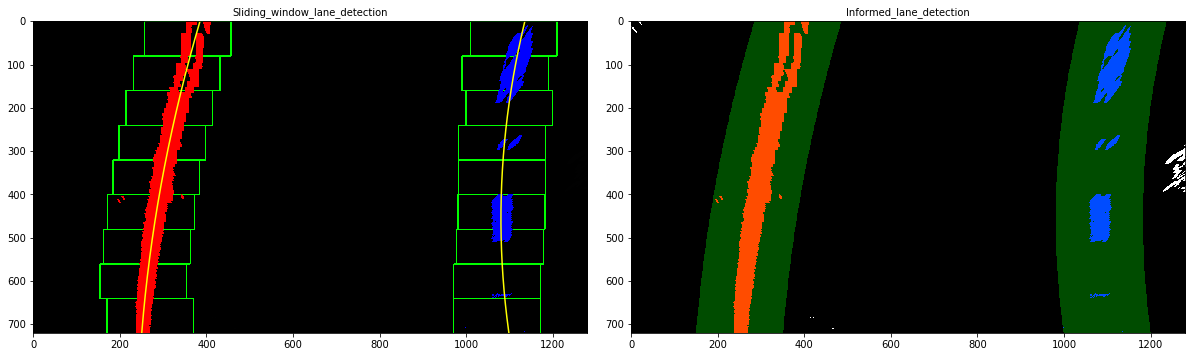

In [6]:
def sliding_window_lane_search(img_binary, plotting=False):
    nwindows = 9
    margin = 100
    minpix = 58 
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img_binary, nwindows,margin,minpix)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_binary.shape[0]-1, img_binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if plotting is True:
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]     
        
    #Get road params
    road_params=get_road_params((left_fitx,right_fitx,ploty))  

    return out_img,(left_fitx,right_fitx,ploty),(left_fit,right_fit),road_params

    
def find_lane_pixels(img_binary,nwindows = 9,margin = 100,minpix = 58 ):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img_binary[img_binary.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img_binary, img_binary, img_binary))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img_binary.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_binary.shape[0] - (window+1)*window_height
        win_y_high = img_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)        

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices 

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img      
    

def informed_lane_search(img_binary,line_fit,plotting= False):       
    
    if line_fit is None:
        return sliding_window_lane_search(img_binary, plotting)

    left_fit = line_fit[0]
    right_fit = line_fit[1]
    # HYPERPARAMETER
    margin = 100

    # Grab activated pixels
    nonzero = img_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    
     # If any of the lines could not be found, use sliding window search
    if (leftx.size == 0 or rightx.size == 0):
        return sliding_window_lane_search(img_binary, plotting)   
    
    #Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_binary.shape[0] - 1, img_binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Get road params
    road_params=get_road_params((left_fitx,right_fitx,ploty))     
    out_img = np.dstack((img_binary, img_binary, img_binary))*255
    if plotting is True:    
        ## Visualization ##
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        ## End visualization steps ##
    return out_img,(left_fitx,right_fitx,ploty),(left_fit,right_fit),road_params

    
def get_road_params(line_pts):                        
    left_fitx=line_pts[0]
    right_fitx=line_pts[1]
    ploty=line_pts[2]
    
    #Measure curvature and car position
    ym_per_pix = 30./720 # meter to pixel
    xm_per_pix = 3.7/700 # meter to pixel
    
    leftx = left_fitx[::-1]  # Reverse to match top-to-bottom in y
    rightx = right_fitx[::-1]  # Reverse to match top-to-bottom in y
    y_eval = np.max(ploty)

    # Fit a second order polynomial to pixel positions in each lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curve_rad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curve_rad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])                                                 
    
    #Measure right line intersection and left lane intersection wrt image_width/2
    car_pos_px = (leftx[-1] + rightx[-1])/2
    car_pos_wrt_center_px=car_pos_px-img_size[1]//2
    car_pos_wrt_center_m=car_pos_wrt_center_px*xm_per_pix
    return (left_curve_rad,right_curve_rad, car_pos_wrt_center_m)
    
img_sliding_window_lane,lane_fit_params,lane_fit,road_params = sliding_window_lane_search(top_down_color, plotting=True)
img_informed_lane,lane_fit_params,lane_fit,road_params= informed_lane_search(top_down_color,lane_fit, plotting=True)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
ax1.imshow(img_sliding_window_lane)
ax1.set_title('Sliding_window_lane_detection', fontsize=10)
# Plots the left and right polynomials on the lane lines
ax1.plot(lane_fit_params[0],lane_fit_params[2],color='yellow')
ax1.plot(lane_fit_params[1],lane_fit_params[2],color='yellow')
ax2.imshow(img_informed_lane)
ax2.set_title('Informed_lane_detection', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
print('Curvatures, dist from center=', road_params)


## Project lanes back to world view

Text(0.5,1,'Original image with lane overlay')

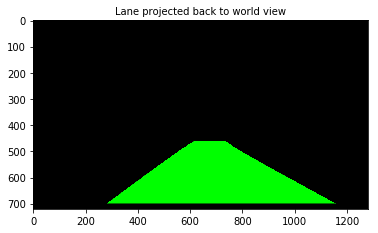

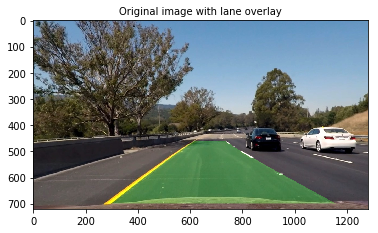

In [7]:
def transform_top_down_to_world_view(img_top_down,src,dst):
    img_top_down_size=(img_top_down.shape[1],img_top_down.shape[0])
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_world = cv2.warpPerspective(img_top_down, Minv, img_top_down_size, flags=cv2.INTER_LINEAR)            
    return img_world


def draw_lanes_top_down(top_down_img, lane_fit_params):
    
    left_fitx=lane_fit_params[0]
    right_fitx=lane_fit_params[1]
    ploty=lane_fit_params[2]
    img = np.zeros_like(top_down_img).astype(np.uint8)
    img_color = np.dstack((img,img,img))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(img_color, np.int_([pts]), (0,255, 0))
    return img_color

img_lane=draw_lanes_top_down(top_down_color, lane_fit_params)
img_lane_world=transform_top_down_to_world_view(img_lane,src, dst)
img_overlay=cv2.addWeighted(img, 1, img_lane_world, 0.25, 0)
plt.figure()
plt.imshow(img_lane_world)
plt.title('Lane projected back to world view', fontsize=10)
plt.figure()
plt.imshow(img_overlay)
plt.title('Original image with lane overlay', fontsize=10)


    

## Lane Detection Class

In [8]:
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
#%matplotlib qt
%matplotlib inline


class LaneDetection(object):

    def __init__(self, images):
        nx=9
        ny=6
        self.mtx, self.dist=self.__calibrate_camera(images, nx, ny)
        self.img_size=cv2.imread(images[0]).shape[:2]

        self.src = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right
        
        self.dst = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   



    def cal_undistort(self, image):
        undist = cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
        return undist

    def __calibrate_camera(self, images, nx, ny):
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((nx*ny,3), np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.


        # Step through the list and search for chessboard corners
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)

        if objpoints: #not empty        
            ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        else:        
            ret, self.mtx, self.dist, rvecs, tvecs = (None, None, None, None, None)

        return self.mtx, self.dist

    def color_thresh(self,rgb_img, color_space,channel_num, low_threshold, high_threshold):
        
        if color_space is 'RGB':
            img_color=np.copy(rgb_img)   
            
        elif color_space is 'HLS':
            img_color=cv2.cvtColor(rgb_img,cv2.COLOR_RGB2HLS)               
        elif color_space is 'HSV':
            img_color=cv2.cvtColor(rgb_img,cv2.COLOR_RGB2HSV)    
        elif color_space is 'LAB':
            img_color=cv2.cvtColor(rgb_img,cv2.COLOR_RGB2Lab)             
        else:
            raise(ValueError, "Invalid color space")  
            
        img_channel=img_color[:,:,channel_num]
        binary_output = np.zeros_like(img_channel)
        binary_output[(img_channel > low_threshold) & (img_channel <= high_threshold)] = 1
        return binary_output

    def abs_sobel_thresh(self,img_gray, orient, sobel_kernel , abs_thresh):
        # 1) Take the derivative in x or y given orient = 'x' or 'y'
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, orient=='x', orient=='y', ksize=sobel_kernel)
        # 2) Take the absolute value of the derivative or gradient
        abs_sobel = np.absolute(sobel)
        # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # 4) Create a mask of 1's where the scaled gradient magnitude 
                # is > thresh_min and < thresh_max
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1
        # 5) Return the mask as a binary_output image
        binary_output = sxbinary # Remove this line
        return binary_output

    def mag_thresh(self,img_gray, sobel_kernel, mag_thresh):

        # 1) Take the gradient in x and y separately
        sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # 2) Calculate the magnitude 
        mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
        # 3) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
        # 4) Create a binary mask where mag thresholds are met
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
        # 5) Return the mask as a binary_output image
        binary_output = np.copy(sxbinary) 
        return binary_output


    def dir_threshold(self,img_gray, sobel_kernel, dir_thresh):    

        # 1) Take the gradient in x and y separately
        sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # 2) Take the absolute value of the x and y gradients
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        # 3) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        grad_dir = np.arctan2(abs_sobely, abs_sobelx)
        # 4) Create a binary mask where direction thresholds are met
        binary_output =  np.zeros_like(grad_dir)
        binary_output[(grad_dir >= dir_thresh[0]) & (grad_dir <= dir_thresh[1])] = 1

        # 5) Return the mask as a binary_output image
        return binary_output

    def get_top_down_view(self,img):
        #input is undist
        img_size=(img.shape[1],img.shape[0])   
        M = cv2.getPerspectiveTransform(self.src, self.dst)    
        warped = cv2.warpPerspective(img, M, img_size)
        return warped
    
    def sliding_window_lane_search(self, img_binary, plotting=False):
        nwindows = 9
        margin = 100
        minpix = 58 
        # Find our lane pixels first
        leftx, lefty, rightx, righty, out_img = self.__find_lane_pixels(img_binary, nwindows,margin,minpix)

        # Fit a second order polynomial to each using `np.polyfit`
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_binary.shape[0]-1, img_binary.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        if plotting is True:
            ## Visualization ##
            # Colors in the left and right lane regions
            out_img[lefty, leftx] = [255, 0, 0]
            out_img[righty, rightx] = [0, 0, 255]            
        #Get road params
        road_params=self.__get_road_params((left_fitx,right_fitx,ploty))  

        return out_img,(left_fitx,right_fitx,ploty),(left_fit,right_fit),road_params

        
    def __find_lane_pixels(self,img_binary,nwindows,margin,minpix ):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(img_binary[img_binary.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((img_binary, img_binary, img_binary))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(img_binary.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img_binary.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img_binary.shape[0] - (window+1)*window_height
            win_y_high = img_binary.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 5) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 5) 

            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices 

        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty, out_img      
        

    def informed_lane_search(self,img_binary,line_fit_prev,plotting= False):       
        
        if not line_fit_prev: #empty list
            return self.sliding_window_lane_search(img_binary, plotting)
    
        left_fit = line_fit_prev[0]
        right_fit = line_fit_prev[1]
        # HYPERPARAMETER
        margin = 100

        # Grab activated pixels
        nonzero = img_binary.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        
         # If any of the lines could not be found, use sliding window search
        if (leftx.size == 0 or rightx.size == 0):
            return sliding_window_lane_search(img_binary, plotting)       
     
        
        #Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_binary.shape[0] - 1, img_binary.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        #Get road params
        road_params=self.__get_road_params((left_fitx,right_fitx,ploty))  
        
        out_img = np.dstack((img_binary, img_binary, img_binary))*255
        if plotting is True:    
            ## Visualization ##
            window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
            ## End visualization steps ##
        return out_img,(left_fitx,right_fitx,ploty),(left_fit,right_fit),road_params

        
    def __get_road_params(self,line_pts):                        
        left_fitx=line_pts[0]
        right_fitx=line_pts[1]
        ploty=line_pts[2]
        
        #Measure curvature and car position
        ym_per_pix = 30./720 # meter to pixel
        xm_per_pix = 3.7/700 # meter to pixel
        
        leftx = left_fitx[::-1]  # Reverse to match top-to-bottom in y
        rightx = right_fitx[::-1]  # Reverse to match top-to-bottom in y
        y_eval = np.max(ploty)

        # Fit a second order polynomial to pixel positions in each lane line
        left_fit = np.polyfit(ploty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fit = np.polyfit(ploty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 25/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/800 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the new radii of curvature
        left_curve_rad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curve_rad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])                                                 
        
        #Measure right line intersection and left lane intersection wrt image_width/2
        car_pos_px = (leftx[-1] + rightx[-1])/2
        car_pos_wrt_center_px=car_pos_px-self.img_size[1]//2
        car_pos_wrt_center_m=car_pos_wrt_center_px*xm_per_pix
        return (left_curve_rad,right_curve_rad, car_pos_wrt_center_m)      
    
        
    def transform_top_down_to_world_view(self,img_top_down):
        img_top_down_size=(img_top_down.shape[1],img_top_down.shape[0])#width,height
        Minv = cv2.getPerspectiveTransform(self.dst, self.src)
        img_world = cv2.warpPerspective(img_top_down, Minv, img_top_down_size)            
        return img_world


    def draw_lanes_top_down(self,top_down_img,lane_fit_params):        
        left_fitx=lane_fit_params[0]
        right_fitx=lane_fit_params[1]
        ploty=lane_fit_params[2]
        img = np.zeros_like(top_down_img).astype(np.uint8)
        img_color = np.dstack((img,img,img))
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        cv2.fillPoly(img_color, np.int_([pts]), (0,255, 0))
        return img_color
    
    def annotate_img(self,img,road_params):
         # Annotate img with road params
        avg_curvature=(road_params[0]+road_params[1])/2
        
        #text='Radius (right,left)= {0:4.0f} \n ceter_offset= {1:4.2f} m '.format(float(avg_curvature),float(road_params[2]))
        text1='Radius={0:4.0f}m'.format(float(avg_curvature))
        text2='Center offset={0:4.2f}m'.format(float(road_params[2]))       
        img=cv2.putText(img,text1, (900, 285), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255), 3) 
        img=cv2.putText(img,text2, (900, 315), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255), 3) 
        return img
    



## Test Lane Detection Class

Text(0.5,1,'Lane detection')

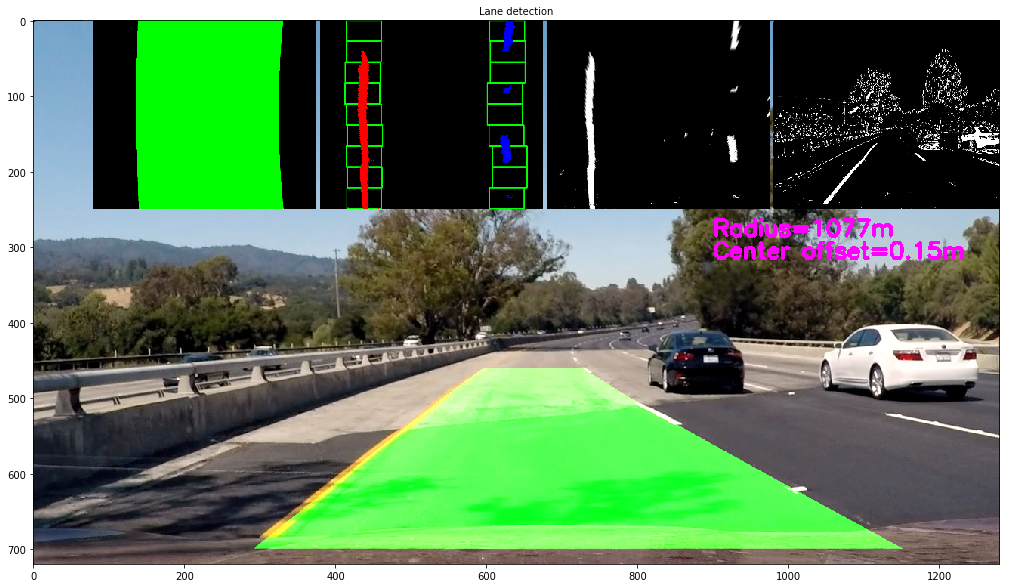

In [9]:

images = glob.glob('./camera_cal/calibration*.jpg')
fname = 'test_images/test4.jpg'
test_img = cv2.imread(fname)
test_img= cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
alg=LaneDetection(images)


def process_image(img):
    
    undist=alg.cal_undistort(test_img)
    img_size=undist.shape
    r_thresh_low =220#should be high for test 1 and 5
    r_thresh_high =255
    s_thresh_low = 190
    s_thresh_high = 255
    l_thresh_low = 225
    l_thresh_high = 255
    b_thresh_low =155
    b_thresh_high =255

    #The S channel does a good job of highlighting yellow lines
    img_s_mask=alg.color_thresh(undist, color_space='HLS',channel_num=2, low_threshold=s_thresh_low, high_threshold=s_thresh_high)
    #Adding for robustness to light
    img_l_mask=alg.color_thresh(undist, color_space='HLS',channel_num=1, low_threshold=l_thresh_low, high_threshold=l_thresh_high)
    #The R channel does a reasonable job of highlighting the lines
    img_r_mask=alg.color_thresh(undist, color_space='RGB',channel_num=0, low_threshold=r_thresh_low , high_threshold=r_thresh_high)
    #B channel in Lab for light sensitivity
    img_b_mask=alg.color_thresh(undist, color_space='LAB',channel_num=2, low_threshold=b_thresh_low , high_threshold=b_thresh_high)   
    #Combined
    img_combined_color=np.zeros_like(img_s_mask)
    img_combined_color[((img_l_mask == 1) | (img_b_mask == 1) | (img_s_mask == 1)) ] = 1
  
    #-----------------Edge detection--------------------#
    # Convert to HLS space
    hls = cv2.cvtColor(np.copy(undist), cv2.COLOR_RGB2HLS)
    # Separate and get the S channel
    #img_s = hls[:, :, 2] #works better with grady
    img_s = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)#doesn't work with grady
    
    abs_ksize=3
    mag_ksize=3
    dir_ksize=3
    img_gradx = alg.abs_sobel_thresh(img_s, orient='x', sobel_kernel=abs_ksize, abs_thresh=(30, 120))
    img_grady = alg.abs_sobel_thresh(img_s, orient='y', sobel_kernel=abs_ksize, abs_thresh=(20, 120))
    img_mag_binary = alg.mag_thresh(img_s, sobel_kernel=mag_ksize, mag_thresh=(70, 100))
    img_dir_binary = alg.dir_threshold(img_s, sobel_kernel=dir_ksize, dir_thresh=(0.7, 1.3))
    img_combined_edges=np.zeros_like(img_s)
    # img_combined_edges[((img_gradx == 1) & (img_grady == 1)) | ((img_mag_binary == 1) & (img_dir_binary == 1)) ] = 1
    img_combined_edges[(img_gradx == 1) | ((img_mag_binary == 1) & (img_dir_binary == 1)) ] = 1  
   
    img_combined=np.zeros((img_size[0],img_size[1]))
    img_combined[((img_combined_edges == 1) |  (img_combined_color == 1)) ] = 1
    
    #Top Down View
    top_down_color = alg.get_top_down_view(img_combined)
    img_sliding_window,lane_fit_params,lane_fit,road_params = alg.sliding_window_lane_search(top_down_color, plotting=True)
    out_img,lane_fit_params,lane_fit,road_params= alg.informed_lane_search(top_down_color,lane_fit, plotting=True)
    img_lane=alg.draw_lanes_top_down(top_down_color,lane_fit_params)
    img_lane_world=alg.transform_top_down_to_world_view(img_lane)
    img_overlay=cv2.addWeighted(img, 1, img_lane_world, 1, 0)
    img_annotated=alg.annotate_img(img_overlay, road_params)
    img_annotated[0:250,980:1280, 0] =cv2.resize(img_combined*255,(300,250))
    img_annotated[0:250,980:1280, 1] =cv2.resize(img_combined*255,(300,250))
    img_annotated[0:250,980:1280, 2] =cv2.resize(img_combined*255,(300,250))
    img_annotated[0:250,680:975, 0] =cv2.resize(top_down_color*255,(295,250))
    img_annotated[0:250,680:975, 1] =cv2.resize(top_down_color*255,(295,250))
    img_annotated[0:250,680:975, 2] =cv2.resize(top_down_color*255,(295,250))
    img_annotated[0:250,380:675, :] =cv2.resize(img_sliding_window,(295,250))
    img_annotated[0:250,80:375, :] =cv2.resize(img_lane,(295,250))
    
    
    return img_annotated

result=process_image(test_img)
plt.figure(figsize=(20,10))
plt.imshow(result)
plt.title('Lane detection', fontsize=10)


## Video Pipeline

Text(0.5,1,'Lane detection')

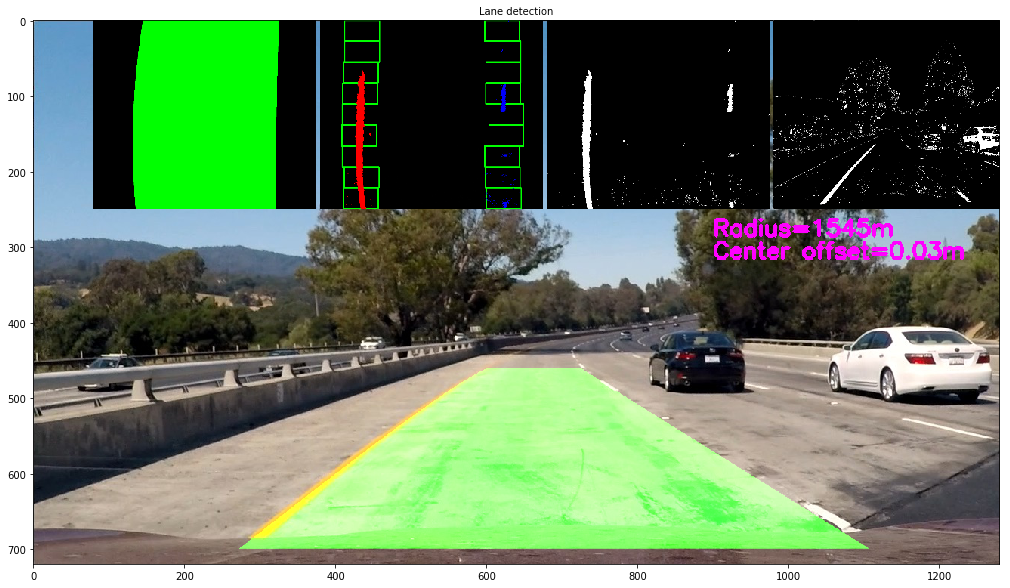

In [1]:
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import deque
#%matplotlib qt
%matplotlib inline


class LaneDetection_From_Video(object):
    
    def __init__(self, images):
        nx=9
        ny=6
        self.mtx, self.dist=self.__calibrate_camera(images, nx, ny)
        self.img_size=cv2.imread(images[0]).shape[:2]


        self.src = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right
        
        self.dst = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right 

        # Define conversions in x and y from pixels space to meters
        self.ym_per_pix = 25/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/800 # meters per pixel in x dimension

        self.lane_fit=None
        self.lane_fit_pts=None
        self.road_params=None
        bins=25
        self.left_fit_params_buffer=deque(maxlen=bins)
        self.right_fit_params_buffer=deque(maxlen=bins)
        self.road_params_buffer=deque(maxlen=bins)

        self.weights = np.arange(1,bins+1)/bins



    def cal_undistort(self, image):
        undist = cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
        return undist

    def __calibrate_camera(self, images, nx, ny):
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((nx*ny,3), np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.


        # Step through the list and search for chessboard corners
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)

        if objpoints: #not empty        
            ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        else:        
            ret, self.mtx, self.dist, rvecs, tvecs = (None, None, None, None, None)

        return self.mtx, self.dist

    def color_thresh(self,rgb_img, color_space,channel_num, low_threshold, high_threshold):
        
        if color_space is 'RGB':
            img_color=np.copy(rgb_img)   
            
        elif color_space is 'HLS':
            img_color=cv2.cvtColor(rgb_img,cv2.COLOR_RGB2HLS)   
            
        elif color_space is 'HSV':
            img_color=cv2.cvtColor(rgb_img,cv2.COLOR_RGB2HSV) 
            
        elif color_space is 'LAB':
            img_color=cv2.cvtColor(rgb_img,cv2.COLOR_RGB2Lab) 
            
        else:
            raise(ValueError, "Invalid color space")  
            
        img_channel=img_color[:,:,channel_num]
        binary_output = np.zeros_like(img_channel)
        binary_output[(img_channel > low_threshold) & (img_channel <= high_threshold)] = 1
        return binary_output

    def abs_sobel_thresh(self,img_gray, orient, sobel_kernel , abs_thresh):
        # 1) Take the derivative in x or y given orient = 'x' or 'y'
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, orient=='x', orient=='y', ksize=sobel_kernel)
        # 2) Take the absolute value of the derivative or gradient
        abs_sobel = np.absolute(sobel)
        # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # 4) Create a mask of 1's where the scaled gradient magnitude 
                # is > thresh_min and < thresh_max
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1
        # 5) Return the mask as a binary_output image
        binary_output = sxbinary # Remove this line
        return binary_output

    def mag_thresh(self,img_gray, sobel_kernel, mag_thresh):

        # 1) Take the gradient in x and y separately
        sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # 2) Calculate the magnitude 
        mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
        # 3) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
        # 4) Create a binary mask where mag thresholds are met
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
        # 5) Return the mask as a binary_output image
        binary_output = np.copy(sxbinary) 
        return binary_output


    def dir_threshold(self,img_gray, sobel_kernel, dir_thresh):    

        # 1) Take the gradient in x and y separately
        sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # 2) Take the absolute value of the x and y gradients
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        # 3) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        grad_dir = np.arctan2(abs_sobely, abs_sobelx)
        # 4) Create a binary mask where direction thresholds are met
        binary_output =  np.zeros_like(grad_dir)
        binary_output[(grad_dir >= dir_thresh[0]) & (grad_dir <= dir_thresh[1])] = 1

        # 5) Return the mask as a binary_output image
        return binary_output

    def get_top_down_view(self,img):
        #input is undist
        img_size=(img.shape[1],img.shape[0])   
        M = cv2.getPerspectiveTransform(self.src, self.dst)    
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        return warped
    
    def sliding_window_lane_search(self, img_binary, plotting=False):
        nwindows = 9
        margin = 100
        minpix = 50 
        # Find our lane pixels first
        leftx, lefty, rightx, righty, out_img = self.__find_lane_pixels(img_binary, nwindows,margin,minpix)

        # Fit a second order polynomial to each using `np.polyfit`
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_binary.shape[0]-1, img_binary.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        if plotting is True:
            ## Visualization ##
            # Colors in the left and right lane regions
            out_img[lefty, leftx] = [255, 0, 0]
            out_img[righty, rightx] = [0, 0, 255]            
        #Get road params
        road_params=self.__get_road_params((left_fitx,right_fitx,ploty)) 

#         if self.reject_lane(left_fit,right_fit) is True:
#             return out_img,self.lane_fit_pts,self.lane_fit,self.road_params
#         else:
        self.lane_fit=(left_fit,right_fit)
        self.lane_fit_pts=(left_fitx,right_fitx,ploty)
        self.road_params=road_params
        return out_img,self.lane_fit_pts,self.lane_fit,self.road_params        

        
    def __find_lane_pixels(self,img_binary,nwindows = 9,margin = 100,minpix = 50 ):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(img_binary[img_binary.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((img_binary, img_binary, img_binary))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(img_binary.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img_binary.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img_binary.shape[0] - (window+1)*window_height
            win_y_high = img_binary.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 5) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 5) 

            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices 

        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty, out_img      
        

    def informed_lane_search(self,img_binary,line_fit,plotting= False):       
        
        if not line_fit: #empty list
            return self.sliding_window_lane_search(img_binary, plotting)
    
        left_fit = line_fit[0]
        right_fit = line_fit[1]
        # HYPERPARAMETER
        margin = 100

        # Grab activated pixels
        nonzero = img_binary.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        
         # If any of the lines could not be found, use sliding window search
        if (leftx.size == 0 or rightx.size == 0):
            return self.sliding_window_lane_search(img_binary, plotting)    
        
        #Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_binary.shape[0] - 1, img_binary.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        #Get road params
        road_params=self.__get_road_params((left_fitx,right_fitx,ploty)) 
        out_img = np.dstack((img_binary, img_binary, img_binary))*255
        if plotting is True:    
            ## Visualization ##
            window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
            ## End visualization steps ##           
#             if self.reject_lane(left_fit,right_fit) is True:
#                 return self.sliding_window_lane_search(img_binary,plotting)
#             else:
            self.lane_fit=(left_fit,right_fit)
            self.lane_fit_pts=(left_fitx,right_fitx,ploty)
            self.road_params=road_params
            return out_img,self.lane_fit_pts,self.lane_fit,self.road_params            

        
    def __get_road_params(self,line_pts):                        
        left_fitx=line_pts[0]
        right_fitx=line_pts[1]
        ploty=line_pts[2]
    
        
        leftx = left_fitx[::-1]  # Reverse to match top-to-bottom in y
        rightx = right_fitx[::-1]  # Reverse to match top-to-bottom in y
        y_eval = np.max(ploty)

        # Fit a second order polynomial to pixel positions in each lane line
        left_fit = np.polyfit(ploty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fit = np.polyfit(ploty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*self.ym_per_pix, leftx*self.xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*self.ym_per_pix, rightx*self.xm_per_pix, 2)

        # Calculate the new radii of curvature
        left_curve_rad = ((1 + (2*left_fit_cr[0]*y_eval*self.ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curve_rad = ((1 + (2*right_fit_cr[0]*y_eval*self.ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])                                                 
        return (left_curve_rad,right_curve_rad)      
    
        
    def transform_top_down_to_world_view(self,img_top_down):
        img_top_down_size=(img_top_down.shape[1],img_top_down.shape[0])
        Minv = cv2.getPerspectiveTransform(self.dst, self.src)
        img_world = cv2.warpPerspective(img_top_down, Minv, img_top_down_size, flags=cv2.INTER_LINEAR)            
        return img_world


    def draw_avg_lanes_top_down(self,top_down_img):
        # Generate x and y values for plotting
        left_fit_avg=np.average(self.left_fit_params_buffer,0,self.weights[-len(self.left_fit_params_buffer):])
        right_fit_avg=np.average(self.right_fit_params_buffer,0,self.weights[-len(self.right_fit_params_buffer):])

        ploty = np.linspace(0, self.img_size[0]-1, self.img_size[0])
        left_avg_fitx = left_fit_avg[0]*ploty**2 + left_fit_avg[1]*ploty + left_fit_avg[2]
        right_avg_fitx = right_fit_avg[0]*ploty**2 + right_fit_avg[1]*ploty + right_fit_avg[2]  
        
        img = np.zeros_like(top_down_img).astype(np.uint8)
        img_color = np.dstack((img,img,img))
        pts_left = np.array([np.transpose(np.vstack([left_avg_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_avg_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        cv2.fillPoly(img_color, np.int_([pts]), (0,255, 0))
        return img_color
    
    def draw_lanes_top_down(self,top_down_img,lane_fit_pts):        
        left_fitx=lane_fit_pts[0]
        right_fitx=lane_fit_pts[1]
        ploty=lane_fit_pts[2]
        img = np.zeros_like(top_down_img).astype(np.uint8)
        img_color = np.dstack((img,img,img))
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        cv2.fillPoly(img_color, np.int_([pts]), (0,255, 0))
        return img_color
    
    def annotate_img(self,img):
         # Annotate img with road params
        left_fit_avg=np.average(self.left_fit_params_buffer,0,self.weights[-len(self.left_fit_params_buffer):])
        right_fit_avg=np.average(self.right_fit_params_buffer,0,self.weights[-len(self.right_fit_params_buffer):])
        road_params_avg=np.average(self.road_params_buffer,0,self.weights[-len(self.road_params_buffer):])
        avg_curvature=(road_params_avg[0]+road_params_avg[1])/2    
              
        #Measure right line intersection and left lane intersection wrt image_width/2 
        y_eval = self.img_size[0]
        left_avg_fitx = left_fit_avg[0]*y_eval**2 + left_fit_avg[1]*y_eval + left_fit_avg[2]
        right_avg_fitx = right_fit_avg[0]*y_eval**2 + right_fit_avg[1]*y_eval + right_fit_avg[2] 

        car_pos_px = (left_avg_fitx + right_avg_fitx)/2
        car_pos_wrt_center_px=car_pos_px-(self.img_size[1]/2)
        car_pos_wrt_center_m=car_pos_wrt_center_px*self.xm_per_pix 
        
        
        #text='Radius (right,left)= {0:4.0f} \n ceter_offset= {1:4.2f} m '.format(float(avg_curvature),float(road_params[2]))
        text1='Radius={0:4.0f}m'.format(float(avg_curvature))
        text2='Center offset={0:4.2f}m'.format(float(car_pos_wrt_center_m))       
        img=cv2.putText(img,text1, (900, 285), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255), 3) 
        img=cv2.putText(img,text2, (900, 315), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255), 3)  
        return img
    
                
#     def reject_lane(self,left_fit,right_fit): 
#         if self.lane_fit is None:
#             return False          
#         last_left_fit=self.lane_fit[0]
#         last_right_fit=self.lane_fit[1]
#         current_fit_diff=abs(left_fit[0]-right_fit[0])
#         last_fit_diff=abs(last_left_fit[0]-last_right_fit[0])
#         flag=abs(last_fit_diff-current_fit_diff)/last_fit_diff        
#         if flag<0.05:
#             return False
#         else:
#             return True
        
    def process_image(self,img):       
        undist=self.cal_undistort(img)
                      
        r_thresh_low =220#should be high for test 1 and 5
        r_thresh_high =255
        s_thresh_low = 190
        s_thresh_high = 255
        l_thresh_low = 225
        l_thresh_high = 255
        b_thresh_low =155
        b_thresh_high =255

        #The S channel does a good job of highlighting yellow lines
        img_s_mask=self.color_thresh(undist, color_space='HLS',channel_num=2, low_threshold=s_thresh_low, high_threshold=s_thresh_high)
        #Adding for robustness to light
        img_l_mask=self.color_thresh(undist, color_space='HLS',channel_num=1, low_threshold=l_thresh_low, high_threshold=l_thresh_high)
        #The R channel does a reasonable job of highlighting the lines
        img_r_mask=self.color_thresh(undist, color_space='RGB',channel_num=0, low_threshold=r_thresh_low , high_threshold=r_thresh_high)
        #B channel in Lab for light sensitivity
        img_b_mask=self.color_thresh(undist, color_space='LAB',channel_num=2, low_threshold=b_thresh_low , high_threshold=b_thresh_high)   
        #Combined
        img_combined_color=np.zeros_like(img_s_mask)
        img_combined_color[((img_l_mask == 1) | (img_b_mask == 1) | (img_s_mask == 1)) ] = 1

        #-----------------Edge detection--------------------#
        # Convert to HLS space
        hls = cv2.cvtColor(np.copy(undist), cv2.COLOR_RGB2HLS)
        # Separate and get the S channel
        #img_s = hls[:, :, 2] #works better with grady
        img_s = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)#doesn't work with grady 
        img_s = cv2.equalizeHist(img_s)

        abs_ksize=3
        mag_ksize=3
        dir_ksize=3
        img_gradx = self.abs_sobel_thresh(img_s, orient='x', sobel_kernel=abs_ksize, abs_thresh=(30, 120))
        img_grady = self.abs_sobel_thresh(img_s, orient='y', sobel_kernel=abs_ksize, abs_thresh=(30, 120))
        img_mag_binary = self.mag_thresh(img_s, sobel_kernel=mag_ksize, mag_thresh=(70, 100))
        img_dir_binary = self.dir_threshold(img_s, sobel_kernel=dir_ksize, dir_thresh=(0.7, 1.3))
        img_combined_edges=np.zeros_like(img_s)
        img_combined_edges[((img_gradx == 1) & (img_grady == 1)) | ((img_mag_binary == 1) & (img_dir_binary == 1)) ] = 1
        #img_combined_edges[(img_gradx == 1) | ((img_mag_binary == 1) & (img_dir_binary == 1)) ] = 1  

        img_combined=np.zeros_like(img_s)
        img_combined[((img_combined_edges == 1) |  (img_combined_color == 1)) ] = 1                      

       
        #Top Down View
        top_down_color = self.get_top_down_view(img_combined)
        
        #Lane Detection
        img_sliding_window,_,_,_ = self.sliding_window_lane_search(top_down_color, plotting=True)
        out_img,self.lane_fit_pts,self.lane_fit,self.road_params= self.informed_lane_search(top_down_color,self.lane_fit, plotting=True)
        
        self.left_fit_params_buffer.append(self.lane_fit[0])
        self.right_fit_params_buffer.append (self.lane_fit[1])   
        self.road_params_buffer.append(self.road_params)
        
        
#       img_lane=self.draw_lanes_top_down(top_down_color,self.lane_fit_pts)
        img_lane=self.draw_avg_lanes_top_down(top_down_color)
        img_lane_world=self.transform_top_down_to_world_view(img_lane)
        img_overlay=cv2.addWeighted(img, 1, img_lane_world, 1, 0) 
        img_annotated=self.annotate_img(img_overlay)   
        img_annotated[0:250,980:1280, 0] =cv2.resize(img_combined*255,(300,250))
        img_annotated[0:250,980:1280, 1] =cv2.resize(img_combined*255,(300,250))
        img_annotated[0:250,980:1280, 2] =cv2.resize(img_combined*255,(300,250))
        img_annotated[0:250,680:975, 0] =cv2.resize(top_down_color*255,(295,250))
        img_annotated[0:250,680:975, 1] =cv2.resize(top_down_color*255,(295,250))
        img_annotated[0:250,680:975, 2] =cv2.resize(top_down_color*255,(295,250))
        img_annotated[0:250,380:675, :] =cv2.resize(img_sliding_window,(295,250))
        img_annotated[0:250,80:375, :] =cv2.resize(img_lane,(295,250))
        return img_annotated


images = glob.glob('./camera_cal/calibration*.jpg')
fname = 'test_images/test1.jpg'
test_img = cv2.imread(fname)
test_img= cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
alg=LaneDetection_From_Video(images)

result=alg.process_image(test_img)
plt.figure(figsize=(20,10))
plt.imshow(result)
plt.title('Lane detection', fontsize=10)



In [2]:
#Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

ModuleNotFoundError: No module named 'imageio_ffmpeg'

In [ ]:
images = glob.glob('./camera_cal/calibration*.jpg')
alg=LaneDetection_From_Video(images)
output = 'test_videos_output/project_solution.mp4'
#clip1 = VideoFileClip("./project_video.mp4").subclip(40,45)#test onlythe challanging part
clip1 = VideoFileClip("./project_video.mp4")
clip = clip1.fl_image(alg.process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)



In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))